In [20]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import fft
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import butter, filtfilt
from scipy.signal import find_peaks
import neurokit2 as nk

In [21]:
def generate_triangle_wave(freq, duration, sampling_rate):
    body_mevement_t = np.linspace(0, duration, int(duration * sampling_rate), endpoint=False)
    triangle_wave = 0.038 * np.abs(2 * (body_mevement_t * freq - np.floor(0.5 + body_mevement_t * freq)))
    return  triangle_wave

In [22]:
#Parameters
TARGET_DISTANCE =0.4

maxR = 11 #Maximum range in meter
maxV = 70 
fc = 60e9 #Carrier frequency
c = 3e8 # speed of light

v0 = 0 #target velocity
FPS=20# 20 frame per second
MONITORING_DURATION = 300  # Duration in seconds
CPF=2# 2 chirp per frame
Nd = MONITORING_DURATION * FPS * CPF# number of chirps
Nr = 256 #number of sample per chirp

B=3.75 * (1e9) #Bandwidth
rangeRes = c/(2*B) #Range resolution
Tchirp = 91.72 * (1e-6) #time of chirp or chirp duration
slope = B/Tchirp 

t0 = np.linspace(0,Tchirp,Nr,endpoint=False)  #sai cho time chirp
t=np.tile(t0,Nd)
t=t.flatten()
print("range resolution {0} mm".format(rangeRes*1e3))


SIMULATED_SAMPLING_RATE =FPS*Nr *CPF

r0 = np.ones(len(t)) #target distance


frequency = 1.0  # Frequency of the triangle wave in Hz
duration = MONITORING_DURATION  # Duration of the waveform in seconds
sampling_rate = SIMULATED_SAMPLING_RATE  # Number of samples per second (standard audio sampling rate)

triangle_wave = generate_triangle_wave(frequency, duration, SIMULATED_SAMPLING_RATE)


r0 =triangle_wave +TARGET_DISTANCE

#r0=triangle_wave
# r0[:len(t)//2] =TARGET_DISTANCE
# r0[len(t)//2:] =TARGET_DISTANCE

Fs = Nr/Tchirp  #Sampling rate of radar signal

amplitude_TX=5
amplitude_RX=5

angle_freq = fc*t+(slope*t*t)/2 
freq = fc + slope*t 
Tx = amplitude_TX *np.cos(2*np.pi*angle_freq)

r0 = r0+v0*t # target distance with velocity is 0
# td = 2*r0/c #time delay
tx = t
freqRx = fc + slope*(t)

breathing_freq = 35  # in minute
heart_freq = 113  # in minute

sampling_rate = FPS*Nr *CPF # Sampling rate in Hz of heart and breath = (frame per second) * (chirp per frame) * (sample per frame)

#ecg50 = 0.005 *nk.ecg_simulate(duration=MONITORING_DURATION, noise=0.07, heart_rate=heart_freq,sampling_rate= SIMULATED_SAMPLING_RATE)
ecg50 = 0.005 * nk.rsp_simulate(duration=MONITORING_DURATION,noise=0.00, respiratory_rate=heart_freq,sampling_rate=SIMULATED_SAMPLING_RATE)
rsp7 = 0.005 * nk.rsp_simulate(duration=MONITORING_DURATION,noise=0.00, respiratory_rate=breathing_freq,sampling_rate=SIMULATED_SAMPLING_RATE, method="breathmetrics")



range resolution 40.0 mm


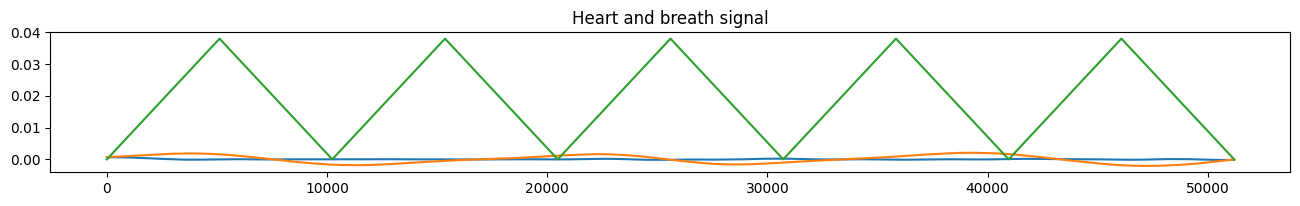

In [23]:
plt.figure(figsize=(16,4))
plt.subplot(211)
plt.plot(ecg50[:SIMULATED_SAMPLING_RATE*5],label="Heart")
plt.plot(rsp7[:SIMULATED_SAMPLING_RATE*5],label="Breath")
plt.title("Heart and breath signal")
#plt.show()

# plt.figure(figsize=(16,4))
# plt.subplot(212)
plt.plot( triangle_wave[:SIMULATED_SAMPLING_RATE*5],label="Body movement")
plt.show()

In [24]:

breath_heart_vibration_displacement =rsp7 +ecg50
td = 2*(r0+breath_heart_vibration_displacement)/c
Rx = amplitude_RX *np.cos(2*np.pi*(fc*(t-td) + (slope*(t-td)*(t-td))/2)) 



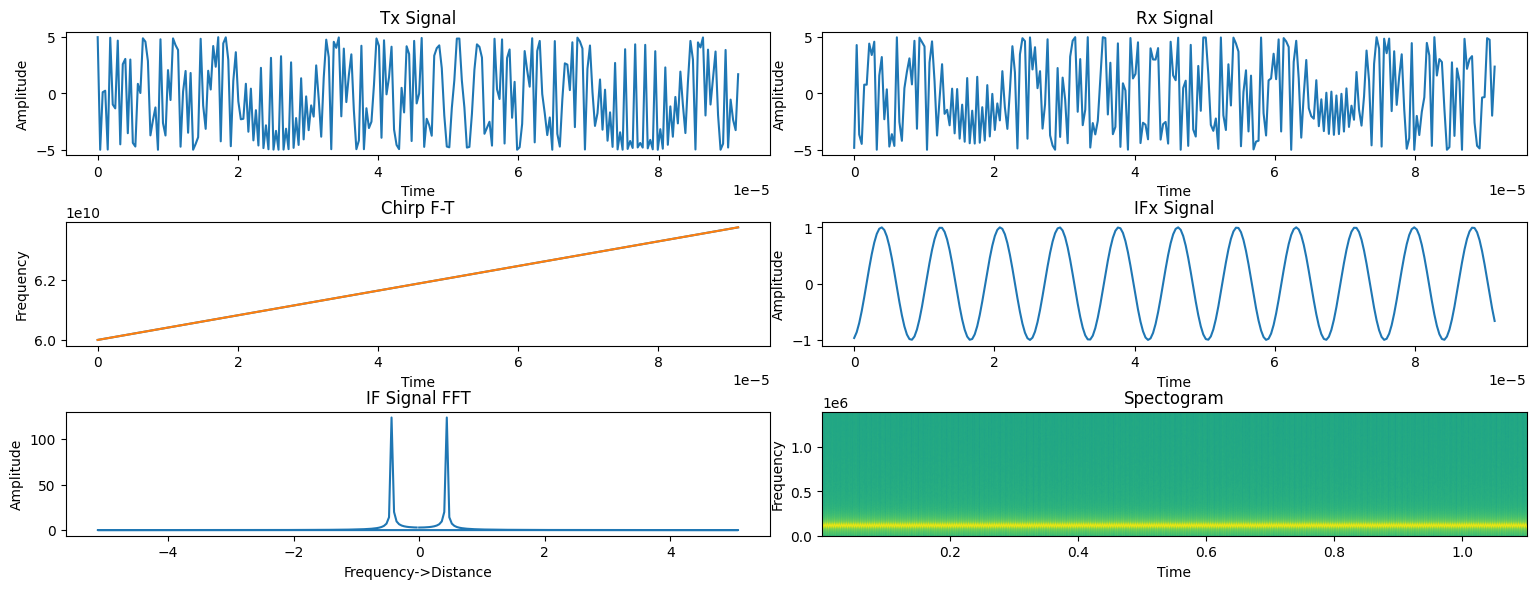

In [25]:
plt.figure(figsize=(16,8))

plt.subplot(4,2,1)
plt.plot(t[0:Nr],Tx[0:Nr])
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Tx Signal')

plt.subplot(4,2,3)
plt.plot(t[0:Nr],freq[0:Nr])
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Tx F-T')

plt.subplot(4,2,2)
plt.plot(t[0:Nr],Rx[0:Nr])
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Rx Signal')
plt.subplot(4,2,3)
plt.plot(t[0:Nr]+td[0:Nr],freqRx[0:Nr])
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Chirp F-T')

IFx = np.cos(-(2*np.pi*(fc*(t-td) + (slope*(t-td)*(t-td))/2))+(2*np.pi*angle_freq))

plt.subplot(4,2,4)
plt.plot(t[0:Nr],IFx[0:Nr])
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('IFx Signal')

#Range FFT

doppler = np.abs(np.fft.fft(IFx[0:Nr]))
frequency = np.fft.fftfreq(Nr, 1/Fs)
range_freq = frequency*c/(2*slope)
plt.subplot(4,2,5)
plt.plot(range_freq[0:Nr],doppler[0:Nr])
plt.xlabel('Frequency->Distance')
plt.ylabel('Amplitude')
plt.title('IF Signal FFT')

#2D plot
plt.subplot(4,2,6)
plt.specgram(IFx,Nr,Fs)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Spectogram')

plt.tight_layout(pad=3, w_pad=0.05, h_pad=0.05)
plt.show()

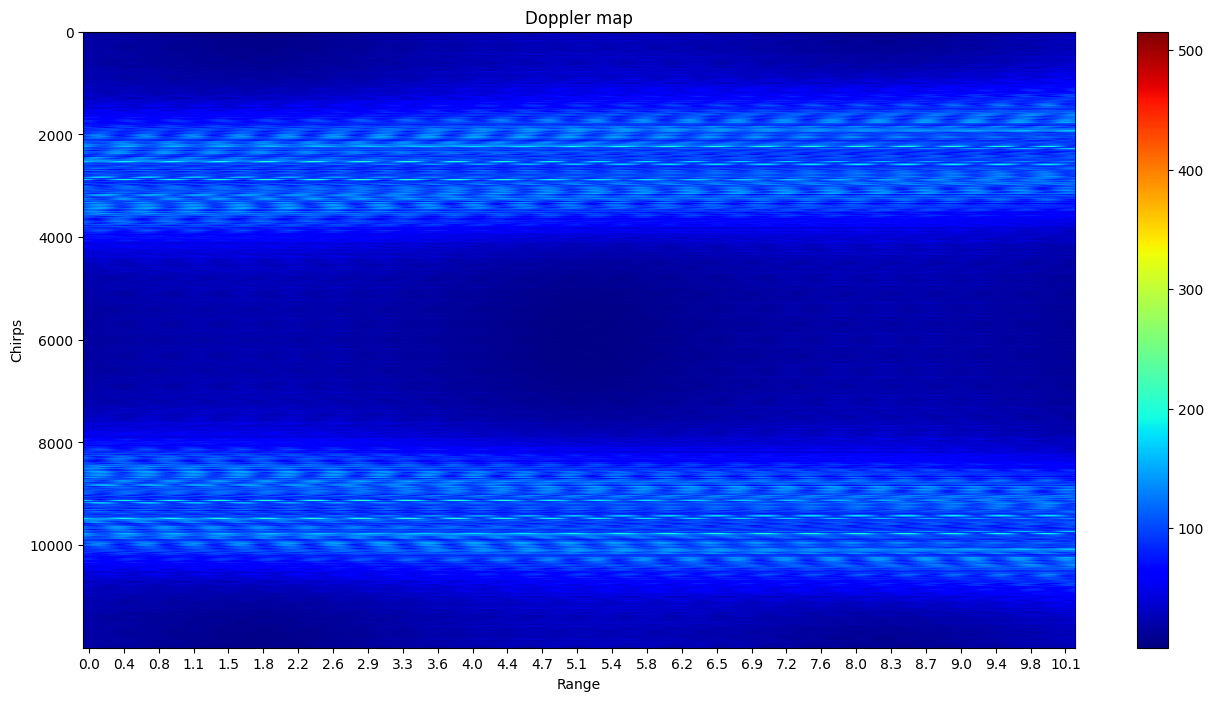

In [45]:
IFMatrix =IFx.reshape(Nd,Nr)
rangeProfile = IFMatrix
dopplerMatrix =np.fft.fft (IFMatrix,axis=1)


magnitude_doppler = [np.abs(profile) for profile in dopplerMatrix]
range_fre = frequency*c/(2*slope)
rangeBinDistance = [round(j*rangeRes,1) for j in range(1,Nr,9) ]


plt.figure(figsize=(16,8))
plt.xlabel('Range')
plt.ylabel('Chirps')
plt.imshow(magnitude_doppler,aspect='auto',cmap='jet')
plt.colorbar()
plt.xticks(range(1,Nr,9), rangeBinDistance)
plt.title("Doppler map")
plt.show()


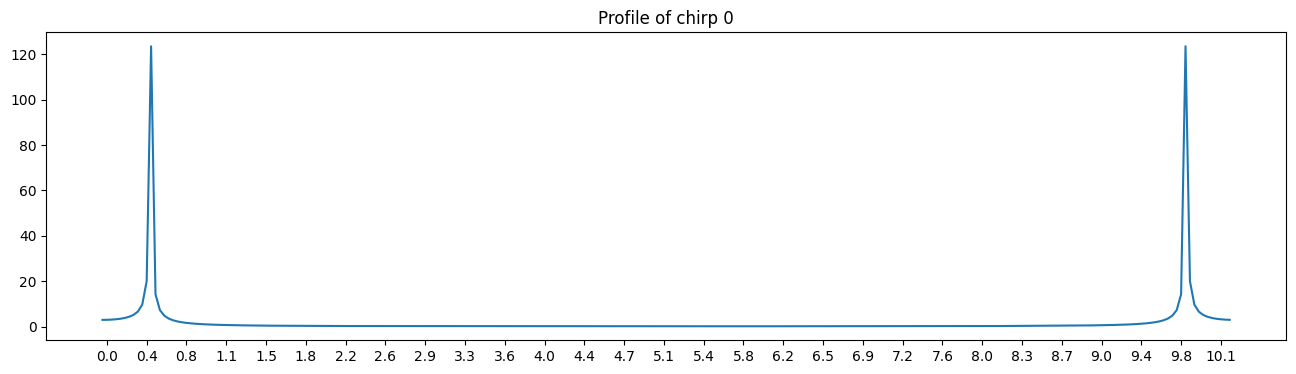

In [27]:
plt.figure(figsize=(16,4))
plt.plot(np.abs(np.fft.fft(rangeProfile[0])))
plt.xticks(range(1,Nr,9), rangeBinDistance)
plt.title("Profile of chirp 0")
plt.show()

In [28]:
magnitude_range_profile_shape =np.array(magnitude_doppler).shape
max_indices =[0]*magnitude_range_profile_shape[0]
for mag_profile in magnitude_doppler:
    max_index = np.argmax(mag_profile)
    max_indices[max_index]+=1
interesting_bin =np.argmax(max_indices)
print("Target at bin :{0}th, distance: {1}m".format(interesting_bin,interesting_bin* rangeRes))

Target at bin :11th, distance: 0.44m


In [29]:
def extractPhase(interestingRangeBin):
    interestingRangeBinLen =len(interestingRangeBin)
    phaseExtracted = np.zeros(len(interestingRangeBin),dtype=float)
    phaseExtracted[0]=np.angle(interestingRangeBin[0])
    
    for i in range(1,interestingRangeBinLen):        
        tmpPhase =0
        for j in range(1,i):
            I_k=interestingRangeBin[j].real
            Q_k=interestingRangeBin[j].imag
            I_k_prev=interestingRangeBin[j-1].real
            Q_k_prev=interestingRangeBin[j-1].imag
            tmpPhase+= (I_k * (Q_k - Q_k_prev) -(I_k - I_k_prev)* Q_k)/(I_k**2 + Q_k **2)

        phaseExtracted[i]= tmpPhase
    return phaseExtracted

In [30]:
unwrapped_phase_DACM= extractPhase(np.array(dopplerMatrix)[:,interesting_bin])

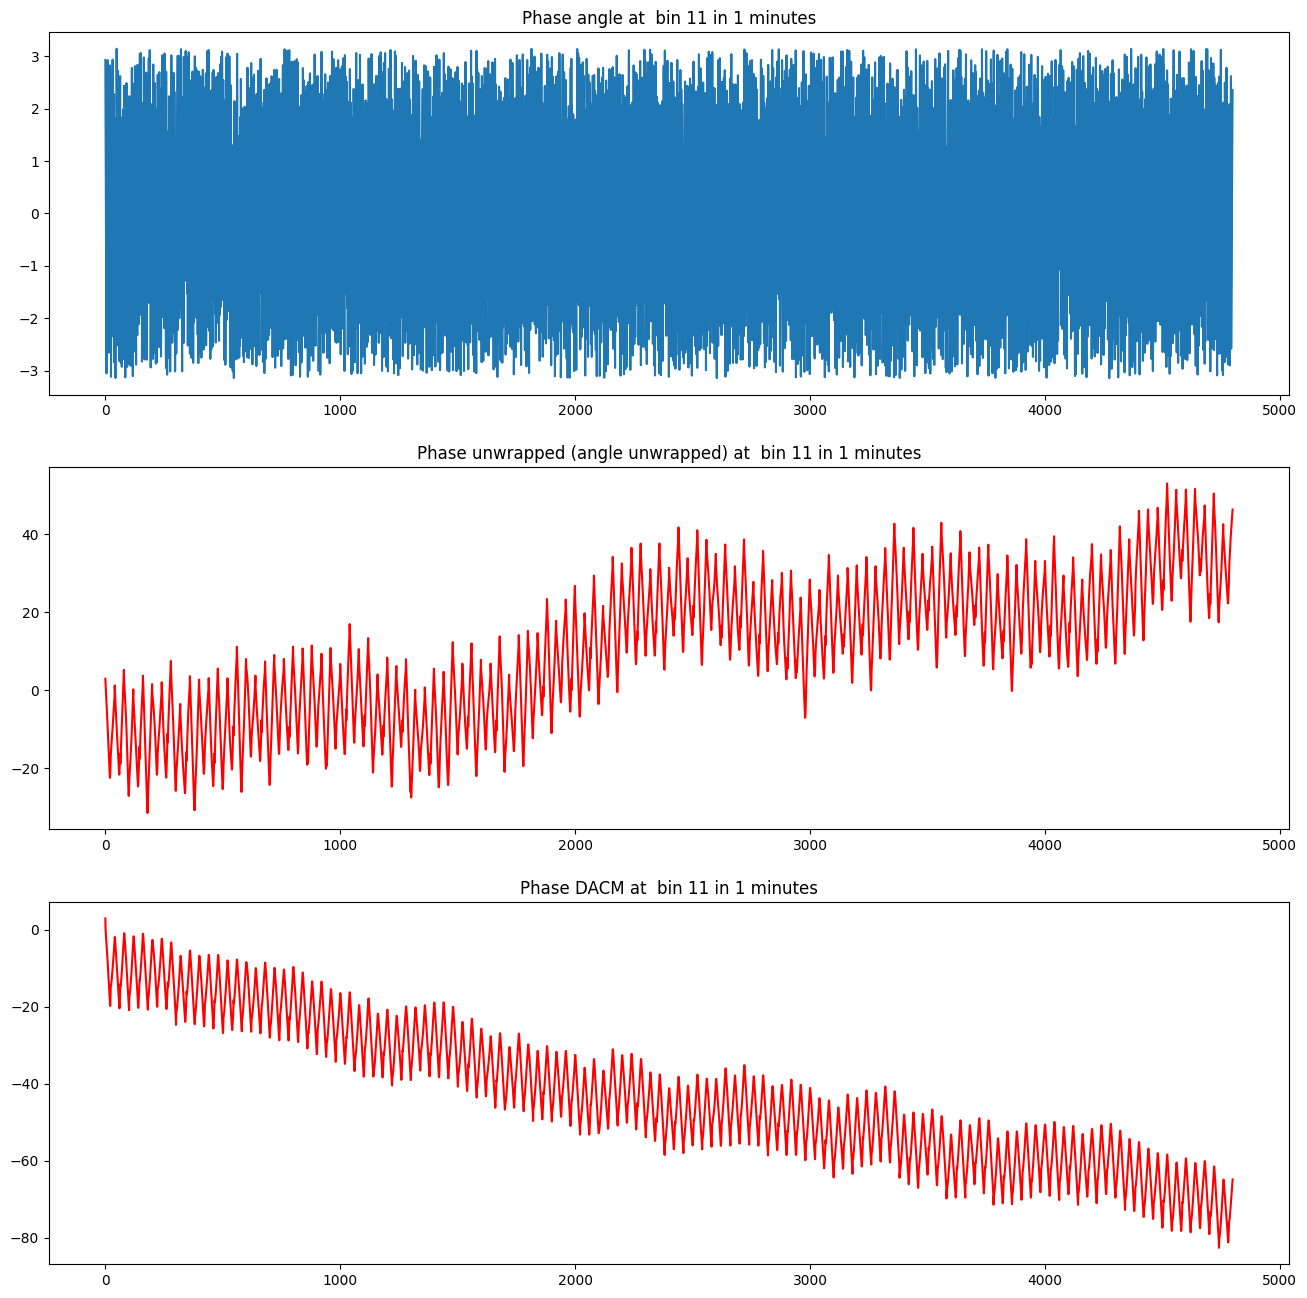

In [31]:
NUM_CHIRP_ONE_MINUTE = FPS *CPF*60
interest_bin_phase = np.array(dopplerMatrix)[:,interesting_bin]
phase_angle =np.angle(interest_bin_phase)
phase_angle_unwrapped = np.unwrap(phase_angle)

plt.figure(figsize=(16,16))

plt.subplot(311)
plt.plot(phase_angle[:NUM_CHIRP_ONE_MINUTE*2])
plt.title("Phase angle at  bin {0} in 1 minutes".format(interesting_bin))

plt.subplot(312)
plt.plot(phase_angle_unwrapped[:NUM_CHIRP_ONE_MINUTE*2],color="red")
plt.title("Phase unwrapped (angle unwrapped) at  bin {0} in 1 minutes".format(interesting_bin))

plt.subplot(313)
plt.plot(unwrapped_phase_DACM[:NUM_CHIRP_ONE_MINUTE*2],color="red")
plt.title("Phase DACM at  bin {0} in 1 minutes".format(interesting_bin))

plt.show()

/Users/truongdinh/Downloads/Children Dataset/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


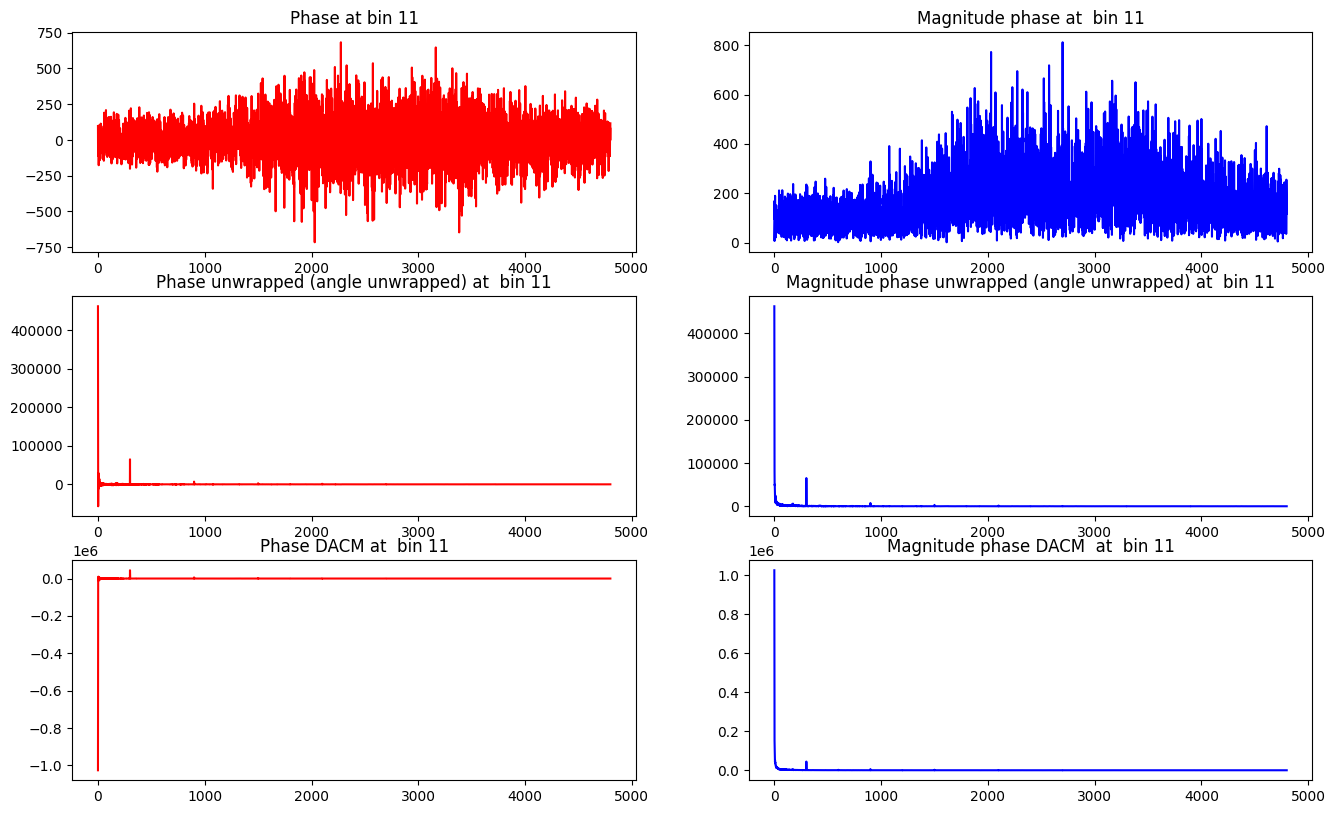

In [32]:

plt.figure(figsize=(16,20))

plt.subplot(621)
plt.plot((np.fft.fft(phase_angle)[:NUM_CHIRP_ONE_MINUTE*2]),color="red")
plt.title("Phase at bin {0}".format(interesting_bin))

plt.subplot(622)
plt.plot(np.abs(np.fft.fft(phase_angle)[:NUM_CHIRP_ONE_MINUTE*2]),color="blue")
plt.title("Magnitude phase at  bin {0}".format(interesting_bin))

plt.subplot(623)
plt.plot((np.fft.fft(phase_angle_unwrapped)[:NUM_CHIRP_ONE_MINUTE*2]),color="red")
plt.title("Phase unwrapped (angle unwrapped) at  bin {0}".format(interesting_bin))

plt.subplot(624)
plt.plot(np.abs(np.fft.fft(phase_angle_unwrapped)[:NUM_CHIRP_ONE_MINUTE*2]),color="blue")
plt.title("Magnitude phase unwrapped (angle unwrapped) at  bin {0}".format(interesting_bin))


plt.subplot(625)
plt.plot((np.fft.fft(unwrapped_phase_DACM)[:NUM_CHIRP_ONE_MINUTE*2]),color="red")
plt.title("Phase DACM at  bin {0}".format(interesting_bin))

plt.subplot(626)
plt.plot(np.abs(np.fft.fft(unwrapped_phase_DACM)[:NUM_CHIRP_ONE_MINUTE*2]),color="blue")
plt.title("Magnitude phase DACM  at  bin {0}".format(interesting_bin))

plt.show()


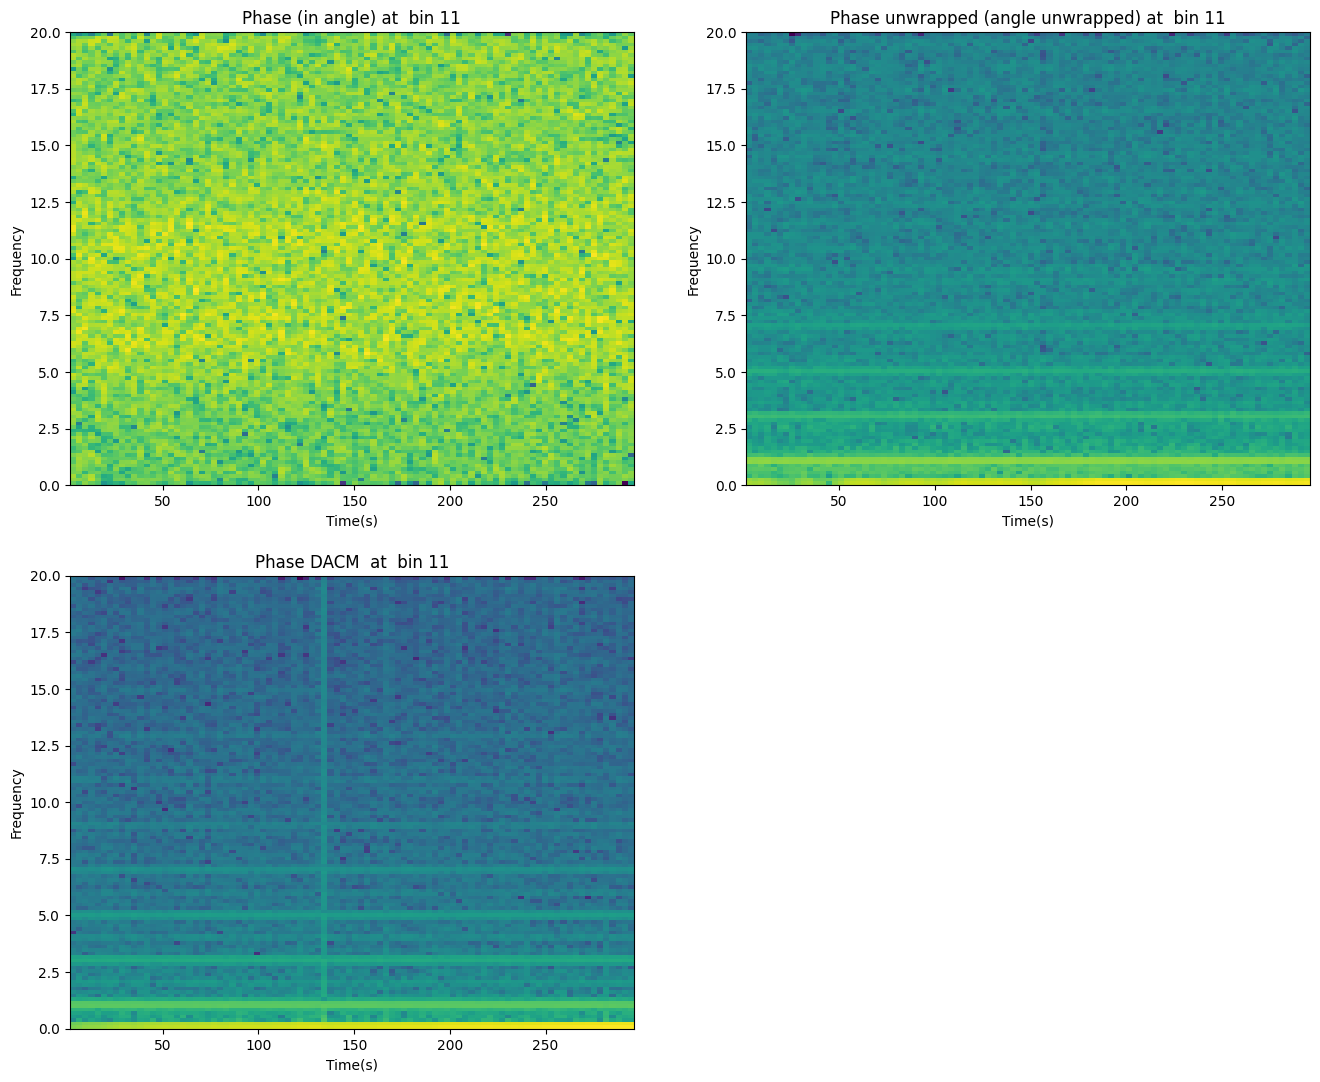

In [33]:
EXTRACTED_SAMPLING_RATE =FPS *CPF

plt.figure(figsize=(16,20))

plt.subplot(321)
plt.specgram(phase_angle,Fs=EXTRACTED_SAMPLING_RATE)
plt.title("Phase (in angle) at  bin {0}".format(interesting_bin))
plt.xlabel("Time(s)")
plt.ylabel("Frequency")

plt.subplot(322)
plt.specgram(phase_angle_unwrapped,Fs=EXTRACTED_SAMPLING_RATE)
plt.title("Phase unwrapped (angle unwrapped) at  bin {0}".format(interesting_bin))
plt.xlabel("Time(s)")
plt.ylabel("Frequency")


plt.subplot(323)
plt.specgram(unwrapped_phase_DACM,Fs=EXTRACTED_SAMPLING_RATE)
plt.title("Phase DACM  at  bin {0}".format(interesting_bin))
plt.xlabel("Time(s)")
plt.ylabel("Frequency")

plt.show()

In [34]:
def filter_signal (signal_to_filter ,_low_freq,_high_freq,_sampling_rate,_filter_order):
    sampling_rate = _sampling_rate# Sampling rate of the input signal
    low_freq = _low_freq  # Lower cutoff frequency of the bandpass filter
    high_freq = _high_freq  # Upper cutoff frequency of the bandpass filter
    filter_order = _filter_order # Order of the bandpass filter

    # Compute the normalized cutoff frequencies
    nyquist_freq = 0.5 * sampling_rate
    low_norm = low_freq / nyquist_freq
    high_norm = high_freq / nyquist_freq
    
    # Design the bandpass filter
    b, a = butter(filter_order, [low_norm, high_norm], btype='band')

    # Apply the bandpass filter to the input signal
    signal_filtered = filtfilt(b, a, signal_to_filter)
    return signal_filtered

In [35]:

#est_signal =phase_angle_unwrapped
est_signal_DACM =unwrapped_phase_DACM

breath_heart_band_filtering=[45/60,125/60]
DACMfiltered_signal =filter_signal(np.array(est_signal_DACM),breath_heart_band_filtering[0],breath_heart_band_filtering[1],EXTRACTED_SAMPLING_RATE,4)

breath_band_filtering=[20/60,60/60]
DACMbreath_filtered_signal =filter_signal(np.array(est_signal_DACM),breath_band_filtering[0],breath_band_filtering[1],EXTRACTED_SAMPLING_RATE,4)

heart_band_filtering=[100/60,150/60]
DACMheart_filtered_signal =filter_signal(np.array(est_signal_DACM),heart_band_filtering[0],heart_band_filtering[1],EXTRACTED_SAMPLING_RATE,4)

In [36]:

est_signal =phase_angle_unwrapped
# est_signal =unwrapped_phase_DACM

breath_heart_band_filtering=[10/60,150/60]
filtered_signal =filter_signal(np.array(est_signal),breath_heart_band_filtering[0],breath_heart_band_filtering[1],EXTRACTED_SAMPLING_RATE,4)

breath_band_filtering=[20/60,60/60]
breath_filtered_signal =filter_signal(np.array(est_signal),breath_band_filtering[0],breath_band_filtering[1],EXTRACTED_SAMPLING_RATE,4)

heart_band_filtering=[100/60,150/60]
heart_filtered_signal =filter_signal(np.array(est_signal),heart_band_filtering[0],heart_band_filtering[1],EXTRACTED_SAMPLING_RATE,4)

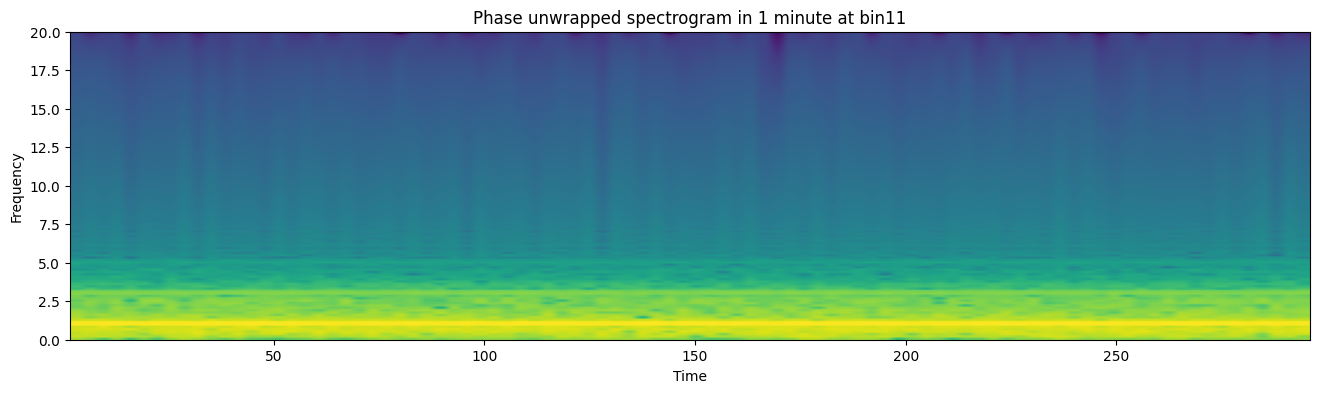

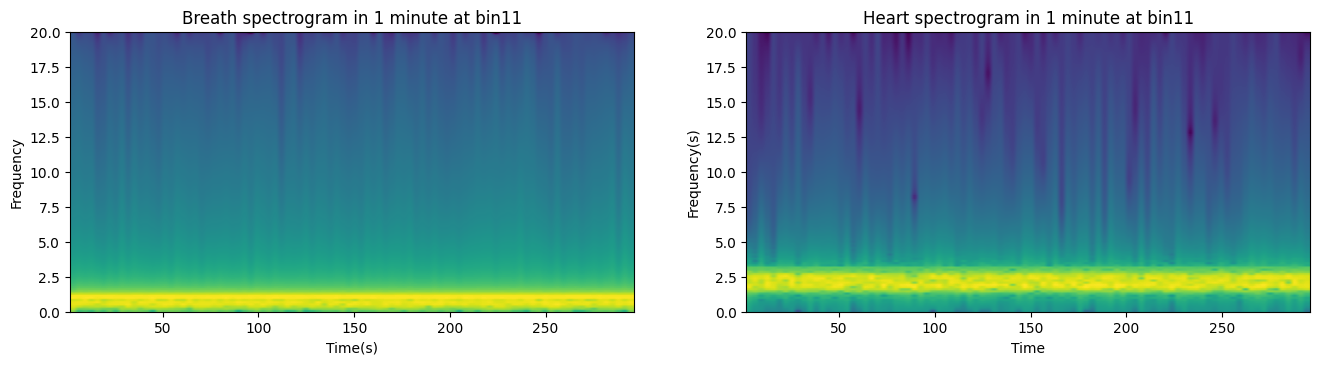

In [37]:
plt.figure(figsize=(16,4))
plt.specgram(filtered_signal,Fs=EXTRACTED_SAMPLING_RATE)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.title("Phase unwrapped spectrogram in 1 minute at bin{0}".format(interesting_bin))
plt.show()

plt.figure(figsize=(16,8))
plt.subplot(221)
plt.specgram(breath_filtered_signal,Fs=EXTRACTED_SAMPLING_RATE)
plt.xlabel("Time(s)")
plt.ylabel("Frequency")
plt.title("Breath spectrogram in 1 minute at bin{0}".format(interesting_bin))

plt.subplot(222)
plt.specgram(heart_filtered_signal,Fs=EXTRACTED_SAMPLING_RATE)
plt.xlabel("Time")
plt.ylabel("Frequency(s)")
plt.title("Heart spectrogram in 1 minute at bin{0}".format(interesting_bin))

plt.show()

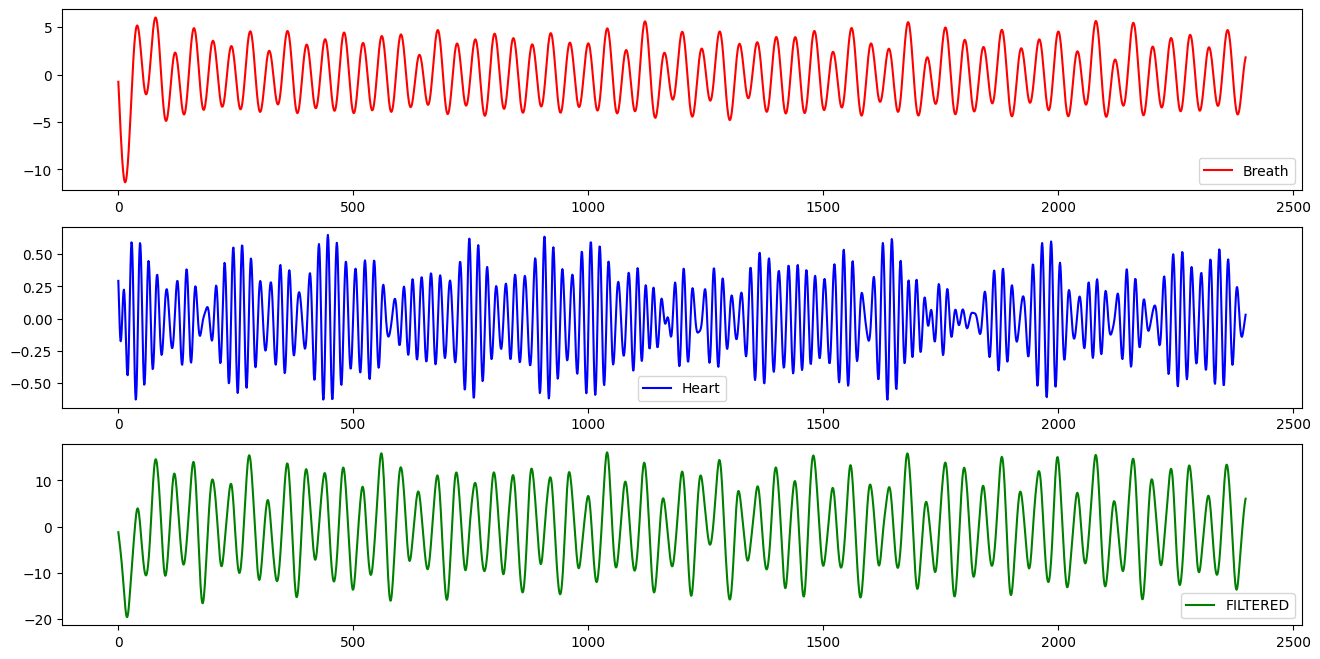

In [38]:
plt.figure(figsize=(16,8))
plt.subplot(311)
plt.plot(DACMbreath_filtered_signal[:NUM_CHIRP_ONE_MINUTE],color="red",label="Breath")
plt.legend()
plt.subplot(312)
plt.plot(DACMheart_filtered_signal[:NUM_CHIRP_ONE_MINUTE],color="blue",label="Heart")
plt.legend()
plt.subplot(313)
plt.plot(filtered_signal[:NUM_CHIRP_ONE_MINUTE],color="green",label="FILTERED")
plt.legend()

plt.show()

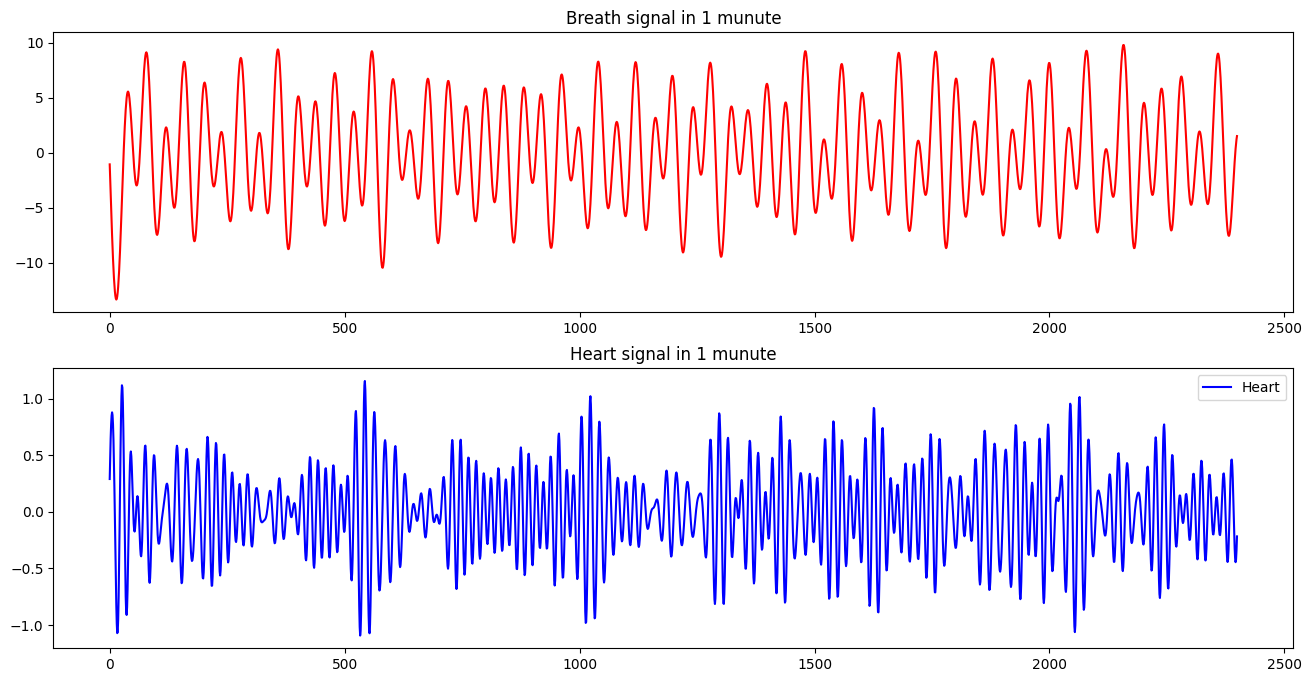

In [39]:
plt.figure(figsize=(16,8))
plt.subplot(211)
plt.plot(breath_filtered_signal[:NUM_CHIRP_ONE_MINUTE],color="red",label="Breath")
plt.title("Breath signal in 1 munute")
plt.subplot(212)
plt.plot(heart_filtered_signal[:NUM_CHIRP_ONE_MINUTE],color="blue",label="Heart")
plt.title("Heart signal in 1 munute")
plt.legend()

plt.show()

In [40]:
def getFreq(theSignal,signalSamplingRate,windowSize,overlapSize):
    freqs=[]
    num_windows = (len(theSignal) - windowSize) // overlapSize + 1
    
    for i in range(num_windows):
        start_index = i * overlapSize
        end_index = start_index + windowSize
        window = theSignal[start_index:end_index]
        hanning_window = np.hanning(windowSize)
        
        fft_output=np.fft.fft(window)

        peaks, _ = find_peaks(np.abs(fft_output))
        peak_frequency = peaks[0] * (1/signalSamplingRate)

        freq_axis =np.fft.fftfreq(len(window), 1/signalSamplingRate)
        sorted_indices = (np.argsort(np.abs(fft_output))[::-1])[:1]
        
        #freqs.append(60*(abs(freq_axis[sorted_indices]))[0])
        freqs.append(60*peak_frequency)

    return freqs

    

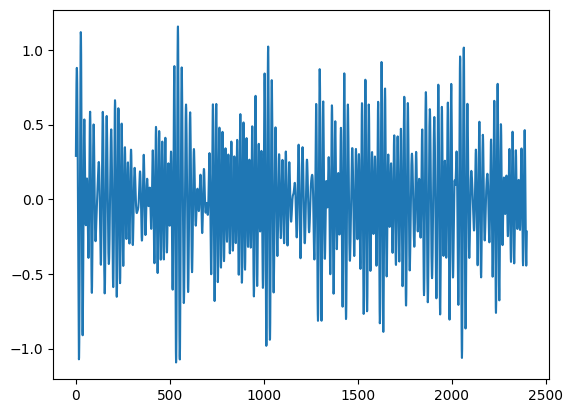

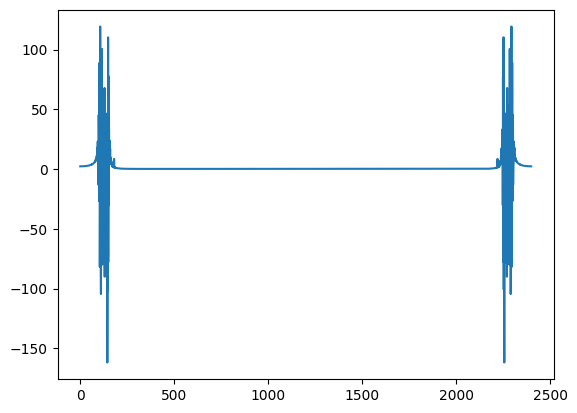

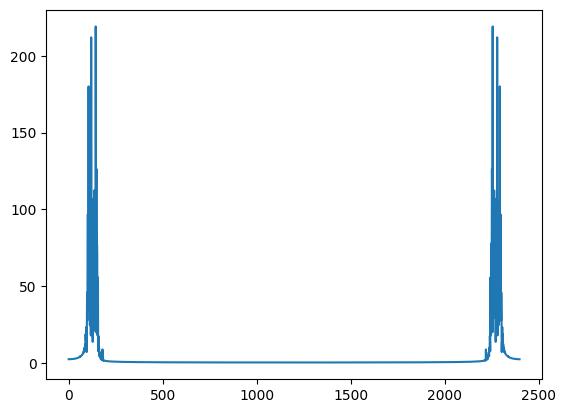

In [41]:
plt.plot(heart_filtered_signal[:2400])
plt.show()
plt.plot(np.fft.fft(heart_filtered_signal[:2400]))
plt.show()
plt.plot(np.abs(np.fft.fft(heart_filtered_signal[:2400])))
plt.show()

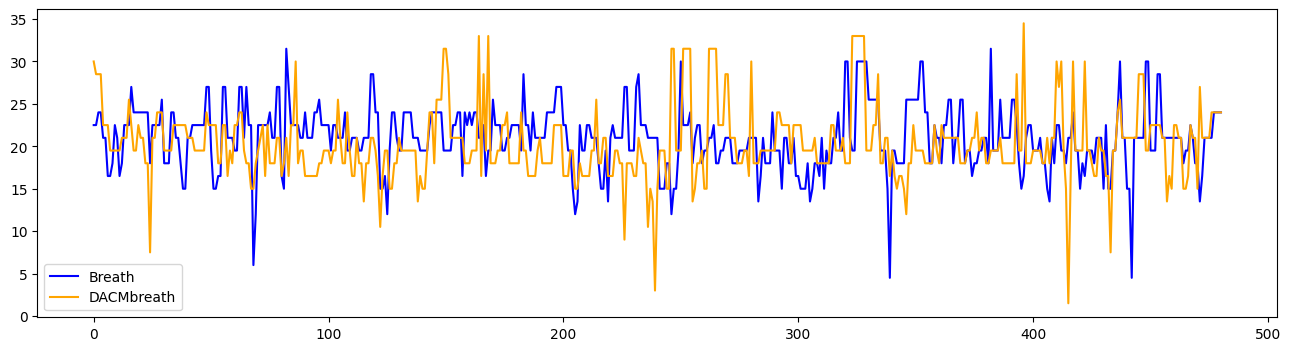

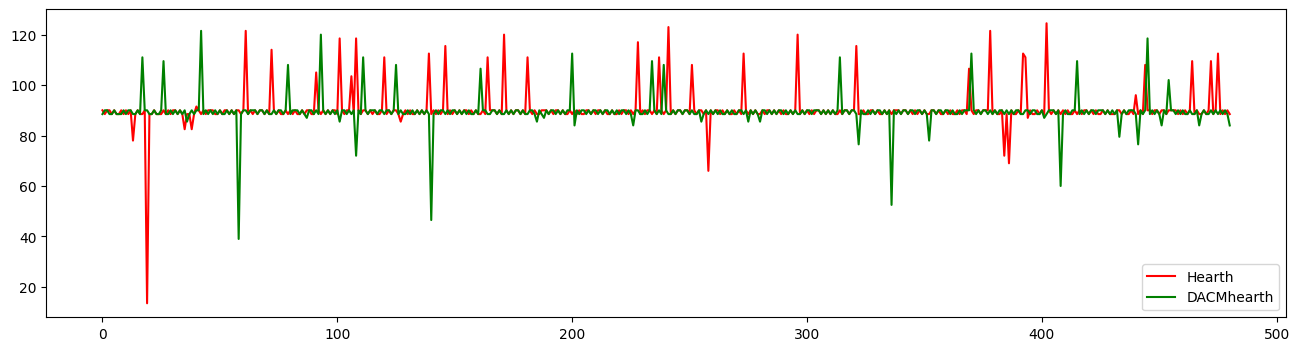

In [42]:

breath_without_filtering =getFreq(filtered_signal,EXTRACTED_SAMPLING_RATE,NUM_CHIRP_ONE_MINUTE,20)
breathfreqs =getFreq(breath_filtered_signal,EXTRACTED_SAMPLING_RATE,NUM_CHIRP_ONE_MINUTE,20)
heartfreqs =getFreq(heart_filtered_signal,EXTRACTED_SAMPLING_RATE,NUM_CHIRP_ONE_MINUTE,20)


DACMbreathfreqs =getFreq(DACMbreath_filtered_signal,EXTRACTED_SAMPLING_RATE,NUM_CHIRP_ONE_MINUTE,20)
DACMheartfreqs =getFreq(DACMheart_filtered_signal,EXTRACTED_SAMPLING_RATE,NUM_CHIRP_ONE_MINUTE,20)

plt.figure(figsize=(16,4))
plt.plot(breathfreqs,label="Breath",color="blue")
plt.plot(DACMbreathfreqs,label="DACMbreath",color="orange")


plt.legend()

plt.show()
plt.figure(figsize=(16,4))
plt.plot(heartfreqs,label="Hearth",color="red")
plt.plot(DACMheartfreqs,label="DACMhearth",color="green")
plt.legend()
plt.show()

